# NNDL [21/22] - Assignment 3 (LunarLander-v2)

### Dr. Alberto Testolin, Dr. Umberto Michieli


Faorlin Tommaso, student ID 2021857 (Physics of Data)

In [21]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
import pyglet
from tqdm.notebook import tqdm
from matplotlib import animation #for the cart we also create a gif

from torch import nn

from collections import deque

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
%config InlineBackend.figure_format='retina'

# Gym environment

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

https://gym.openai.com/envs/LunarLander-v2/

In [2]:
environment_name = 'LunarLander-v2'

### Create environment
env = gym.make(environment_name) # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 8
ACTION SPACE SIZE: 4


## Experience replay (Replay Memory)
"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html). 

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)                # Define a queue with maxlen "capacity"
    
    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))
    
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self))             # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        
        return random.sample(self.memory, batch_size)       # Randomly select "batch_size" samples
    
    def __len__(self):
        
        return len(self.memory)                             # Return the number of samples currently stored in the memory

In [4]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(4, 4, 4, 4), (3, 3, 3, 3)]


## Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with state_space_dim inputs and action_space_dim outputs (e.g. 2 hidden layers with 128 neurons each) with an activation function (e.g. Tanh).

Be sure to keep a linear output activation.

In [5]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [6]:
net = DQN(state_space_dim, action_space_dim)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

In [7]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)                             # The output of DQN are the Q-values

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy
With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

In [8]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()

    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])

    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [9]:
def softmax_exploration(num_iterations=1000, initial_value=5):
    # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
    exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
    return exploration_profile

def moving_average(x, size):
    return (np.arange(size // 2, len(x) - (size - size // 2) + 1), np.convolve(x, np.ones(size), 'valid') / size)

def normalize_profile(profile):
    return (profile - np.min(profile)) / (np.max(profile) - np.min(profile))

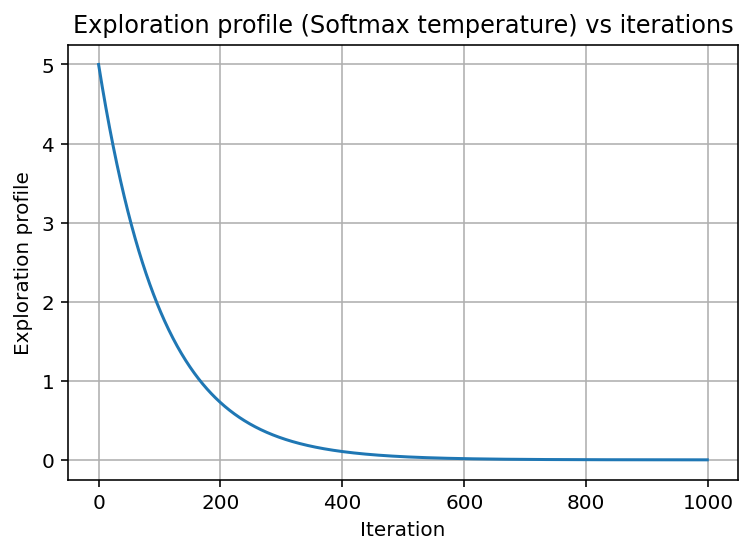

In [10]:
exploration_profile = softmax_exploration()
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile')
plt.title('Exploration profile (Softmax temperature) vs iterations')
plt.show()

## Network update

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [11]:
def initializer(par, replay_memory_capacity=10000, state_space_dim=state_space_dim, action_space_dim=action_space_dim):
    '''
    Function for the initialization of ReplayMemory, Network for Q values (policy and target), 
                                       optimizer and loss function.
    
    '''

    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.Adam(policy_net.parameters(), lr=par['lr']) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [12]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    #Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    #Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    #Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    #Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    #Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [13]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, params,min_samples_for_training, verbose=False):
    # Initialize the Gym environment
    env = gym.make('LunarLander-v2') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score.
        score = 0
        done = False

        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # Update the final score (+1 for each step)
            score += reward

            # Apply penalty for bad state
            if done:
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

            # Visually render the environment (disable to speed up the training)
            #env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        training_score.append(score)
    env.close()
    
    return policy_net, training_score

In [100]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

score_list = []
explp_list = []

exploration_profile = softmax_exploration(initial_value=3)

min_samples_for_training = 500   

params = {'gamma':                   0.99,
          'target_net_update_steps': 10000,
          'batch_size':              64,
          'target_net_update_steps': 5,
          'bad_state_penalty':       0,
          'lr':                      0.001
         }


replay_mem, policy_net, target_net, optimizer, loss_fn = initializer(params)

policy_net, training_score = training_loop(policy_net, 
                                           target_net, 
                                           replay_mem, 
                                           exploration_profile, 
                                           params, 
                                           min_samples_for_training, 
                                           verbose = False)

score_list.append(training_score)
explp_list.append(exploration_profile)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [101]:
#np.save('results/Lunar_softmax.npy', score_list)

score_list = np.load('results/Lunar_softmax.npy')

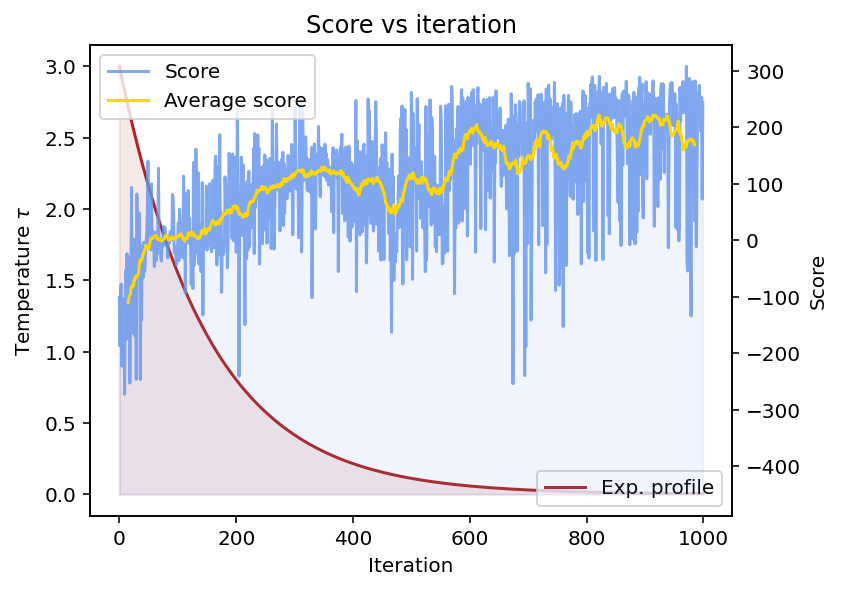

In [103]:
x = np.arange(0,1000,1)

fig, ax1 = plt.subplots(figsize=(6,4) )
ax2 = ax1.twinx()

ax2.plot(score_list[-1], color = 'cornflowerblue', alpha=0.8, label = 'Score')
ax1.plot(explp_list[-1], color = 'firebrick', label='Exp. profile')
ax2.plot(*moving_average(score_list[-1],30), color = 'gold', label='Average score')

ax1.fill_between(x,0,explp_list[-1],color='firebrick', alpha=0.1)
ax2.fill_between(x,-450,score_list[-1],color='cornflowerblue', alpha=0.1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'Temperature $\tau$')

ax2.set_ylabel('Score')  

fig.tight_layout()
ax1.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('Score vs iteration')
filename = 'graphs/lander_notweak.pdf'
plt.savefig(filename)

### Test

In [105]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score.
    score = 0
    done = False
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        #env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended 
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 35.05302498345284
EPISODE 2 - FINAL SCORE: 260.16794046811935
EPISODE 3 - FINAL SCORE: 277.58182519093236
EPISODE 4 - FINAL SCORE: 0.5476787358766018
EPISODE 5 - FINAL SCORE: 223.3625466212318
EPISODE 6 - FINAL SCORE: 222.08566868202016
EPISODE 7 - FINAL SCORE: -12.04427499165999
EPISODE 8 - FINAL SCORE: -0.5084149124915314
EPISODE 9 - FINAL SCORE: 249.63085399878236
EPISODE 10 - FINAL SCORE: 116.2876587648055


# Tune the reward function

In [106]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, params,min_samples_for_training, verbose=False):
    # Initialize the Gym environment
    env = gym.make('LunarLander-v2') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score.
        score = 0
        done = False
        
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            descent_bonus = 1.5*np.abs(state[3]) if state[3] <0 else 0
            
            reward = reward + descent_bonus

            # Update the final score (+1 for each step)
            score += reward

            # Apply penalty for bad state
            if done:
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

            # Visually render the environment (disable to speed up the training)
            #env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        training_score.append(score)
    env.close()
    
    return policy_net, training_score

In [107]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

param_list = []
score_list = []
explp_list = []

exploration_profile = softmax_exploration(initial_value=6)

min_samples_for_training = 500   

params = {'gamma':                   0.99,
          'target_net_update_steps': 10000,
          'batch_size':              64,
          'target_net_update_steps': 5,
          'bad_state_penalty':       0,
          'lr':                      0.001
         }


replay_mem, policy_net, target_net, optimizer, loss_fn = initializer(params)

policy_net, training_score = training_loop(policy_net, 
                                           target_net, 
                                           replay_mem, 
                                           exploration_profile, 
                                           params, 
                                           min_samples_for_training, 
                                           verbose = False)

param_list.append(params)
score_list.append(training_score)
explp_list.append(exploration_profile)

  0%|          | 0/1000 [00:00<?, ?it/s]

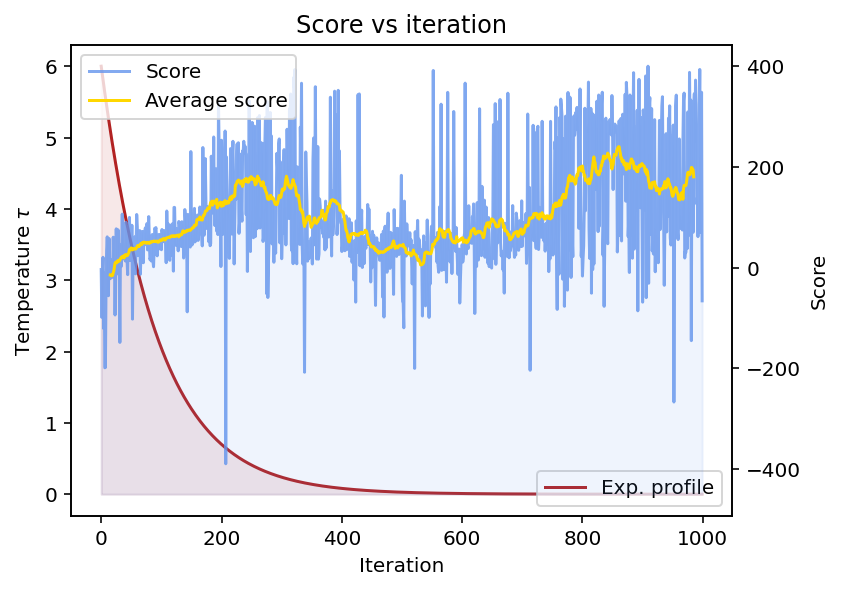

In [108]:
x = np.arange(0,1000,1)

fig, ax1 = plt.subplots(figsize=(6,4) )
ax2 = ax1.twinx()

ax2.plot(score_list[-1], color = 'cornflowerblue', alpha=0.8, label = 'Score')
ax1.plot(explp_list[-1], color = 'firebrick', label='Exp. profile')
ax2.plot(*moving_average(score_list[-1],30), color = 'gold', label='Average score')

ax1.fill_between(x,0,explp_list[-1],color='firebrick', alpha=0.1)
ax2.fill_between(x,-450,score_list[-1],color='cornflowerblue', alpha=0.1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'Temperature $\tau$')

ax2.set_ylabel('Score')  


plt.tight_layout()
ax1.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('Score vs iteration')
filename = 'graphs/Lunar_tweaked.pdf'
plt.savefig(filename)

## $\varepsilon$-greedy policy
We now use an $\varepsilon$-greedy policy with a custom variation of the $\varepsilon$ parameter.

In [14]:
#we change the training loop in order to use the epsilon-greedy policy

def training_loop_egreedy(policy_net, target_net, replay_mem, epsilon_vec, params,min_samples_for_training, verbose=False):
    # Initialize the Gym environment
    env = gym.make('LunarLander-v2') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    training_score = []

    for episode_num, eps in enumerate(tqdm(epsilon_vec)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. 
        score = 0
        done = False

        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_epsilon_greedy(policy_net, state, eps)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # Update the final score (+1 for each step)
            score += reward

            # Apply penalty for bad state
            if done:
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

            # Visually render the environment (disable to speed up the training)
            #env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Epsilon: {eps}") # Print the final score
        training_score.append(score)
    env.close()
    
    return policy_net, training_score

In [15]:
#we code a first epsilon-greedy exploration profile
epsilon_1 = np.full(100, 0.5)
epsilon_2 = np.full(100, 0.2)
epsilon_3 = np.full(400, 0.1)
epsilon_4 = np.full(400, 0.01)

epsilon_vec = np.concatenate((epsilon_1,epsilon_2,epsilon_3,epsilon_4))

In [16]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

score_list = []

min_samples_for_training = 500   

params = {'gamma':                   0.99,
          'target_net_update_steps': 10000,
          'batch_size':              64,
          'target_net_update_steps': 5,
          'bad_state_penalty':       0,
          'lr':                      0.001
         }


replay_mem, policy_net, target_net, optimizer, loss_fn = initializer(params)

policy_net, training_score = training_loop_egreedy(policy_net, 
                                                   target_net, 
                                                   replay_mem, 
                                                   epsilon_vec, 
                                                   params, 
                                                   min_samples_for_training, 
                                                   verbose = False)

score_list.append(training_score)

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-12-8df984b91e37>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/torch/csrc/utils/tensor_new.cpp:201.)
  states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)


In [23]:
#https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553 (code for the gif)
def save_frames_as_gif(frames, path='./',filename='LunarLander.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [32]:
observation = env.reset()
frames = []
state = env.reset()
for t in range(300):
    frames.append(env.render(mode="rgb_array"))
    action, q_values = choose_action_epsilon_greedy(policy_net, state, 0.01)
    next_state, reward, done, info = env.step(action)
    state = next_state
    
    if done:
        break
        
env.close()

MovieWriter imagemagick unavailable; using Pillow instead.


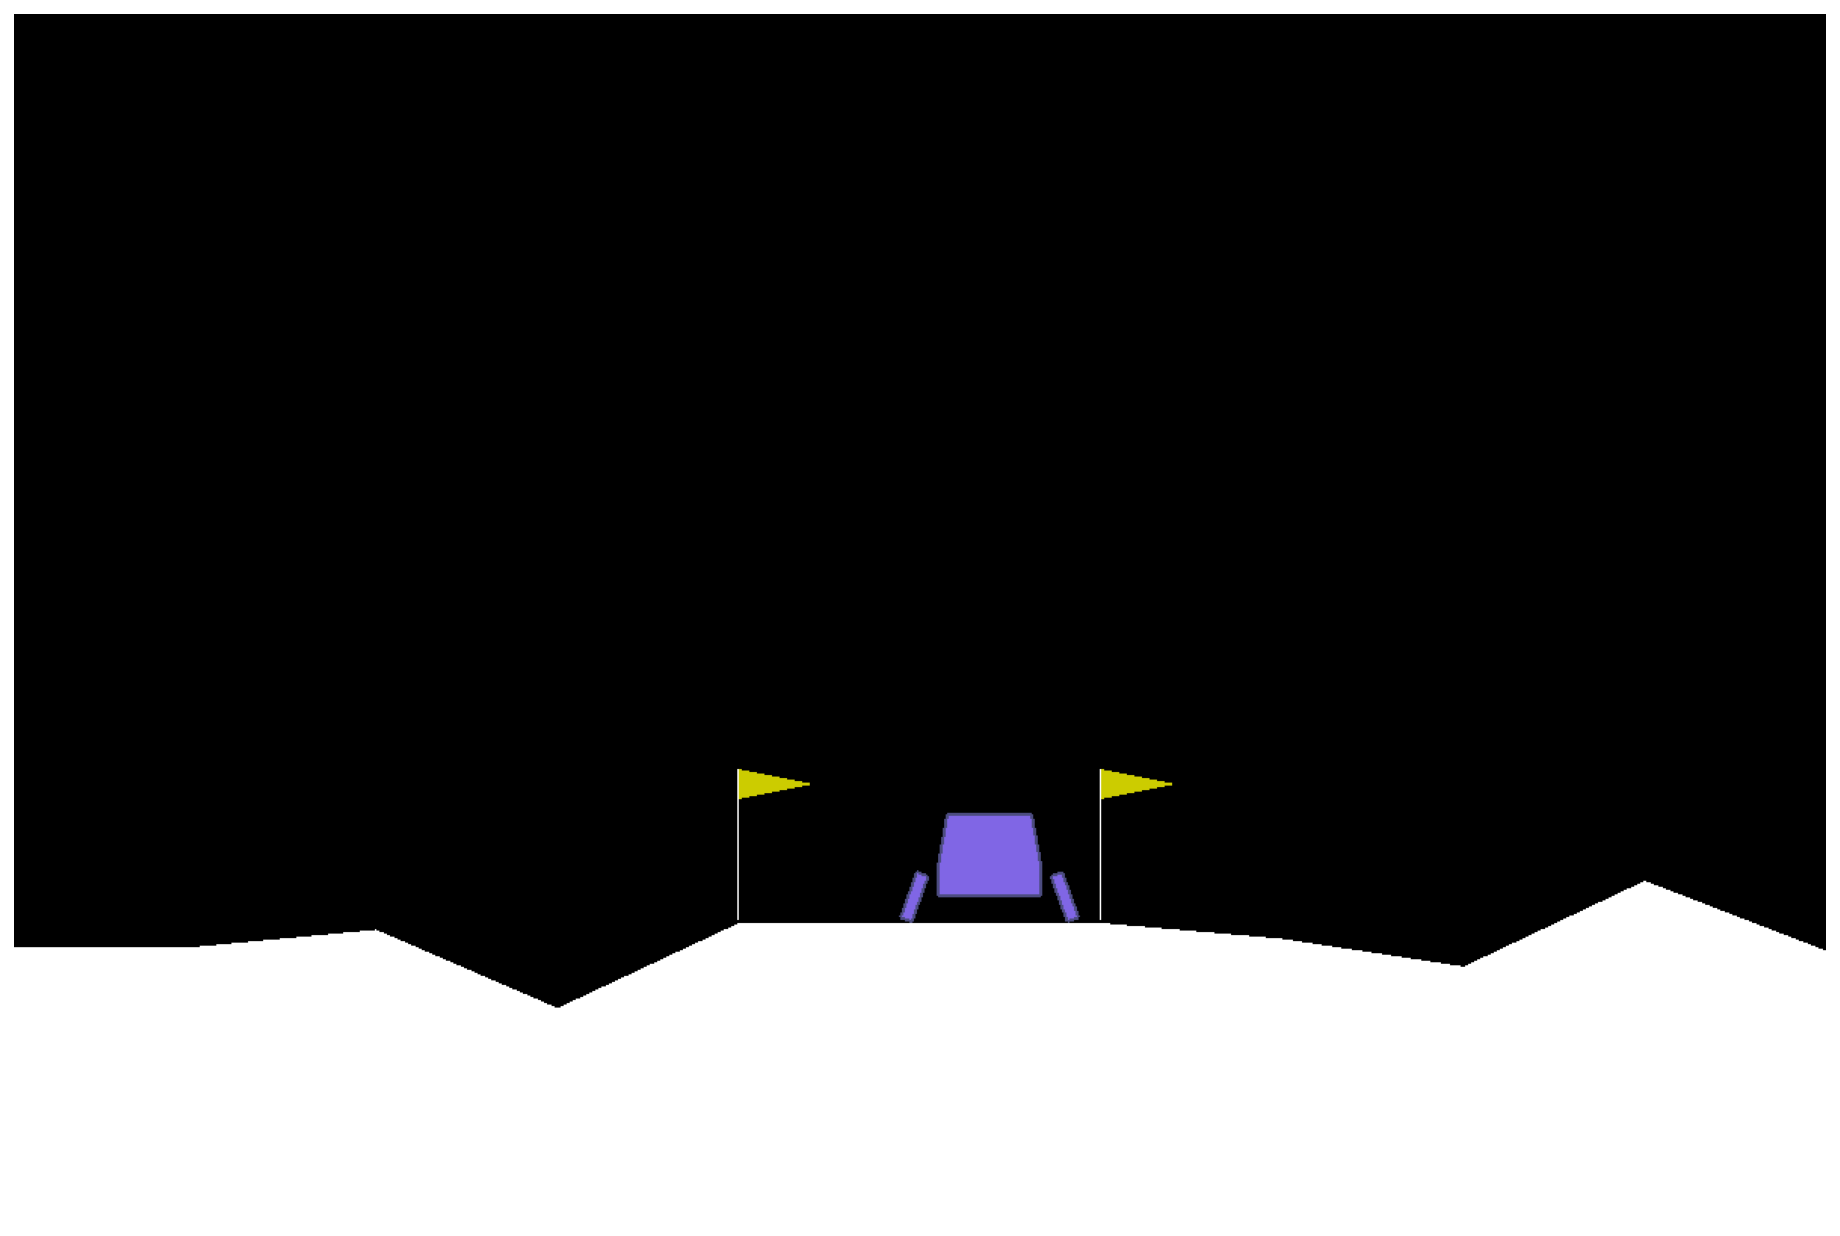

In [33]:
save_frames_as_gif(frames)

In [121]:
#np.save('results/Lunar_greedy.npy', score_list)

score_list = np.load('results/Lunar_greedy.npy')

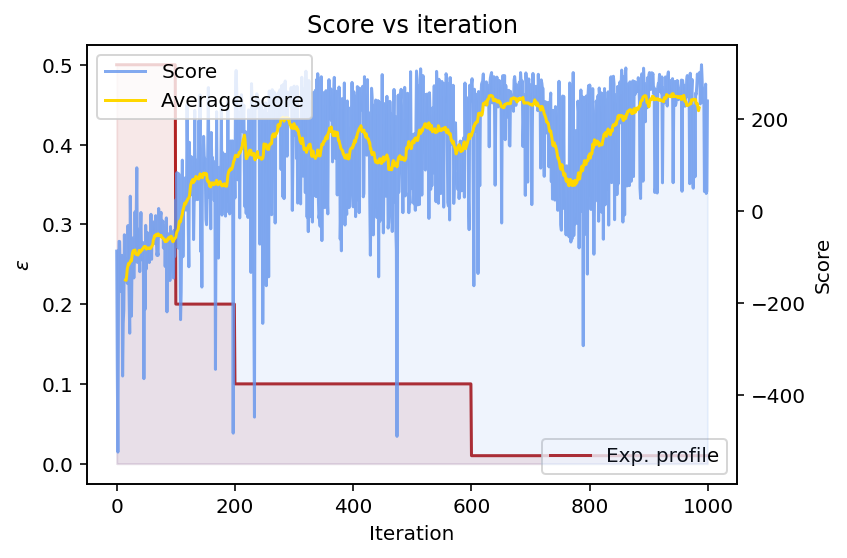

In [29]:
x = np.arange(0,1000,1)

fig, ax1 = plt.subplots(figsize=(6,4) )
ax2 = ax1.twinx()

ax2.plot(score_list[-1], color = 'cornflowerblue', alpha=0.8, label = 'Score')
ax1.plot(epsilon_vec, color = 'firebrick', label='Exp. profile')
ax2.plot(*moving_average(score_list[-1],30), color = 'gold', label='Average score')

ax1.fill_between(x,0,epsilon_vec,color='firebrick', alpha=0.1)
ax2.fill_between(x,-550,score_list[-1],color='cornflowerblue', alpha=0.1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\varepsilon$')

ax2.set_ylabel('Score')  

ax1.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('Score vs iteration')
filename = 'graphs/Lunar_greedy.pdf'
fig.tight_layout()
#plt.savefig(filename)
plt.show()

### Test

In [31]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score.
    score = 0
    done = False
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_epsilon_greedy(policy_net, state, 0.01)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        #env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 275.4370795937431
EPISODE 2 - FINAL SCORE: 152.26511716708742
EPISODE 3 - FINAL SCORE: 239.61049210248652
EPISODE 4 - FINAL SCORE: 280.82224467900426
EPISODE 5 - FINAL SCORE: 5.703418263455119
EPISODE 6 - FINAL SCORE: 258.4648666104335
EPISODE 7 - FINAL SCORE: 243.09001660107148
EPISODE 8 - FINAL SCORE: 72.64083653209838
EPISODE 9 - FINAL SCORE: 266.54430094815655
EPISODE 10 - FINAL SCORE: 277.0386240936075


### Different profile

In [116]:
#we code a second epsilon-greedy exploration profile
exploration_steps = 100
total_steps = 1000
first = np.array([1-0.95/exploration_steps*(i+1) for i in range(exploration_steps)])
last  = np.full(total_steps-exploration_steps,0.05)
epsilon_vec = np.concatenate((first,last))

In [92]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

score_list = []

min_samples_for_training = 500   

params = {'gamma':                   0.99,
          'target_net_update_steps': 10000,
          'batch_size':              64,
          'target_net_update_steps': 5,
          'bad_state_penalty':       0,
          'lr':                      0.001
         }


replay_mem, policy_net, target_net, optimizer, loss_fn = initializer(params)

policy_net, training_score = training_loop_egreedy(policy_net, 
                                                   target_net, 
                                                   replay_mem, 
                                                   epsilon_vec, 
                                                   params, 
                                                   min_samples_for_training, 
                                                   verbose = False)

score_list.append(training_score)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [114]:
#np.save('results/Lunar_greedy2.npy', score_list)

score_list = np.load('results/Lunar_greedy2.npy')

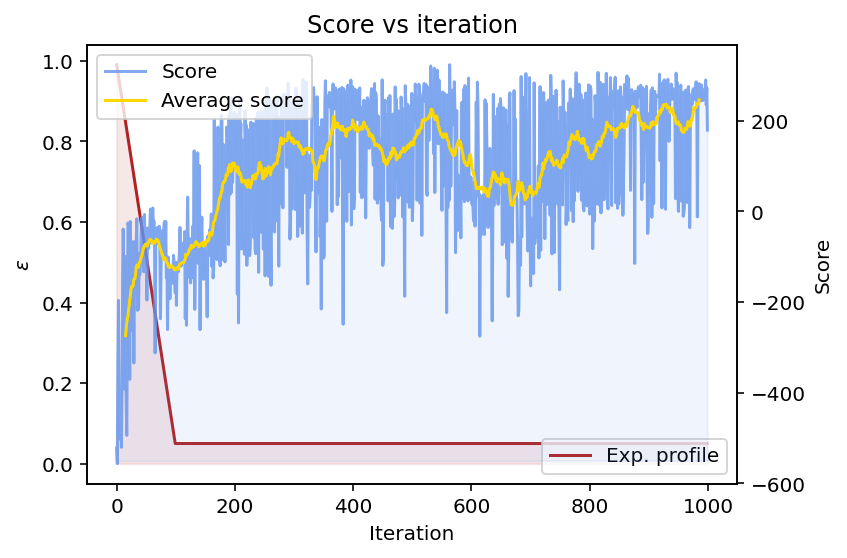

In [117]:
x = np.arange(0,1000,1)

fig, ax1 = plt.subplots(figsize=(6,4) )
ax2 = ax1.twinx()

ax2.plot(score_list[-1], color = 'cornflowerblue', alpha=0.8, label = 'Score')
ax1.plot(epsilon_vec, color = 'firebrick', label='Exp. profile')
ax2.plot(*moving_average(score_list[-1],30), color = 'gold', label='Average score')

ax1.fill_between(x,0,epsilon_vec,color='firebrick', alpha=0.1)
ax2.fill_between(x,-550,score_list[-1],color='cornflowerblue', alpha=0.1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\varepsilon$')

ax2.set_ylabel('Score')  

ax1.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('Score vs iteration')
filename = 'graphs/Lunar_greedy2.pdf'
fig.tight_layout()
plt.savefig(filename)

### Test

In [96]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. 
    score = 0
    done = False
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        #env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 159.1105807080039
EPISODE 2 - FINAL SCORE: 278.3949164207734
EPISODE 3 - FINAL SCORE: 243.06796822318177
EPISODE 4 - FINAL SCORE: 237.58589314684093
EPISODE 5 - FINAL SCORE: 36.481066166591006
EPISODE 6 - FINAL SCORE: 52.93899307754708
EPISODE 7 - FINAL SCORE: 268.19235534886377
EPISODE 8 - FINAL SCORE: 259.21266160542064
EPISODE 9 - FINAL SCORE: 45.93468758031534
EPISODE 10 - FINAL SCORE: 266.74980174023574
